In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, meg_from_spikes
from nengo_learn_assoc_mem.utils import BasicVecFeed
from nengo_learn_assoc_mem.learning_rules.rec_adapt import RecAdapt

from collections import namedtuple
import random

# MEG with full vocab

In [2]:
dimensions = 64
n_neurons = 500
seed = 8

t_present = 0.3
t_pause = 0.5
t_each = t_pause + t_present
dt = 0.001

n_items = 16
n_repeats = 1

In [3]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, \
foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [4]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [63]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                 "fan2": SlcStim(2, True, fan2_slc),
                 "foil1": SlcStim(1, False, foil1_slc),
                 "foil2": SlcStim(2, False, foil2_slc)}

## Train networks on Targets

In [7]:
max_rec_inhib = -0.01
adapt_lr = -1e-4
rec_synapse = 0.05
theta_tau = 0.01
p_n = 0.1

In [8]:
c = nengo.dists.CosineSimilarity(dimensions).ppf(1 - p_n)

In [9]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
random.shuffle(feed_vecs)

In [10]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: 1-feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))
    rec_learn = RecAdapt(n_neurons, np.zeros(n_neurons), learning_rate=(adapt_lr / n_repeats),
                         max_inhib=max_rec_inhib, theta_tau=theta_tau)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, rec_learn.in_neurons, synapse=rec_synapse)
    nengo.Connection(learning, rec_learn.enable, synapse=None)
    # Note: trying to inhibit the neurons when not learning has minimal effect on their decay
    nengo.Connection(rec_learn.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:14.                                                 


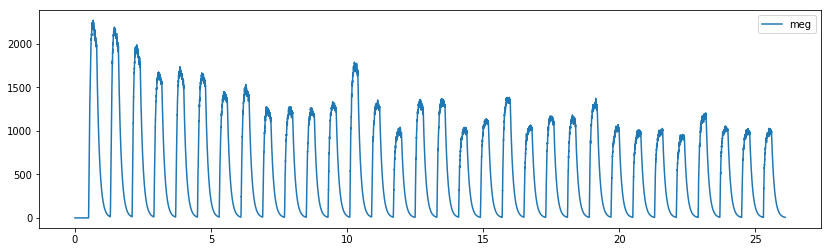

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), meg_from_spikes(sim.data[p_spikes]), label="meg")
plt.legend()

In [12]:
w_hist = np.array(rec_learn.weight_history)
w_hist.shape

(269, 500)

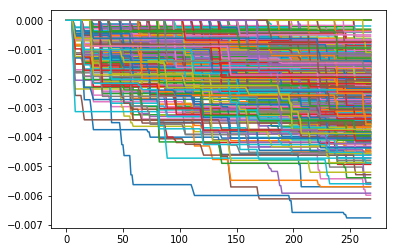

In [53]:
plt.plot(w_hist[:, 100:]);


## Test network on all pairs

In [103]:
rec_w = rec_learn.weight_history[-1]
rec_w.shape

(500,)

In [104]:
diag_idx = np.diag_indices(n_neurons, 2)

In [105]:
rec_transform = np.eye(n_neurons)
rec_transform[diag_idx] = rec_w

In [114]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [58]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as base_model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))

    nengo.Connection(in_nd, ens, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:19.                                                 


In [59]:
base_meg = meg_from_spikes(base_sim.data[p_spikes])

In [115]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)

    rec_trans_nd = nengo.Node(lambda t, x: x * rec_w, size_in=n_neurons, size_out=n_neurons)
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, rec_trans_nd, synapse=rec_synapse)
    nengo.Connection(rec_trans_nd, ens.neurons, synapse=None)
    #nengo.Connection(ens.neurons, ens.neurons, transform=rec_transform, synapse=rec_synapse)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:29.                                                 


In [116]:
meg_resp = meg_from_spikes(learned_sim.data[p_spikes])

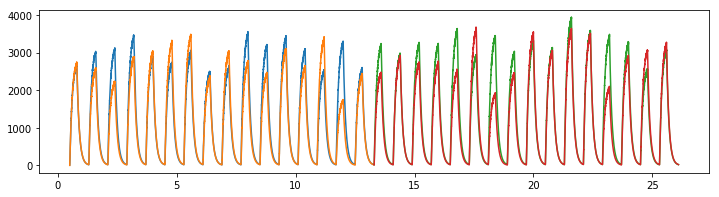

In [117]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_resp[fan1_slc])
plt.plot(sim.trange()[fan1_slc], base_meg[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_resp[fan2_slc])
plt.plot(sim.trange()[fan2_slc], base_meg[fan2_slc])

In [118]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = base_meg[obj.slc] - meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

diff_df = pd.concat(df_list)

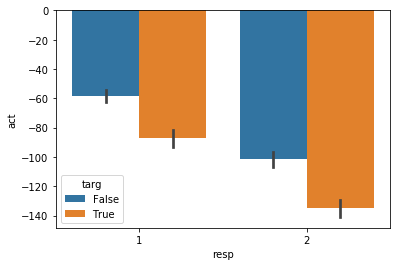

In [119]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=diff_df)

In [120]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

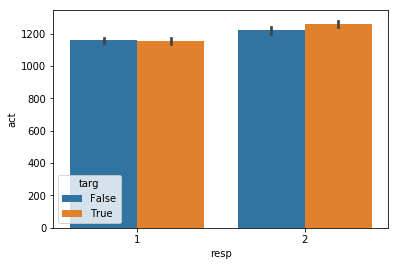

In [122]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

# Classification Accuracy

In [32]:
fan_labels = []
for i1, i2 in fan1+fan2:
    fan_labels.append(f"{i1}+{i2}")

In [33]:
fan_vecs = np.concatenate((fan1_pair_vecs, fan2_pair_vecs))

## Without Voja

In [30]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [31]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: 1-feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_transform, synapse=rec_synapse)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] > 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:35.                                                 


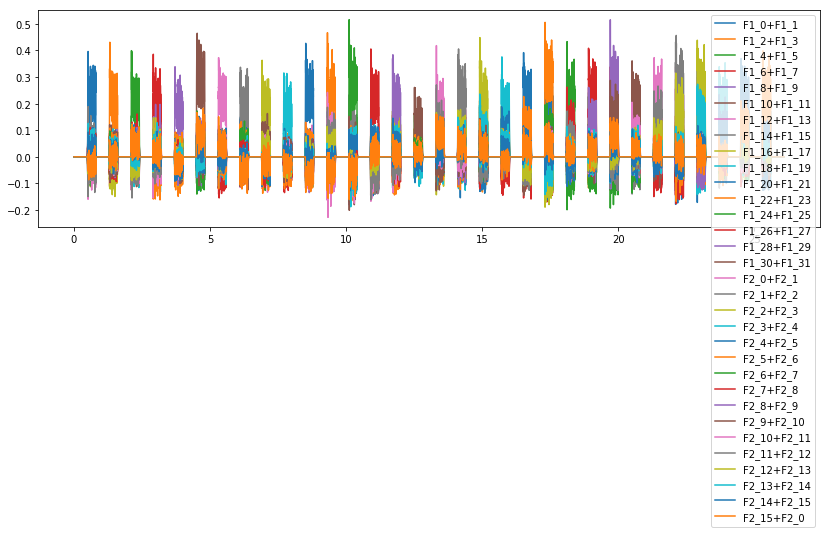

In [34]:
plt.figure(figsize=(14, 4))
plt.plot(learned_sim.trange(), spa.similarity(learned_sim.data[p_out], fan_vecs));
plt.legend(fan_labels)

In [35]:
dec = learned_sim.data[p_dec][-1].copy()

In [36]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_transform, synapse=rec_synapse)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:16.                                                 


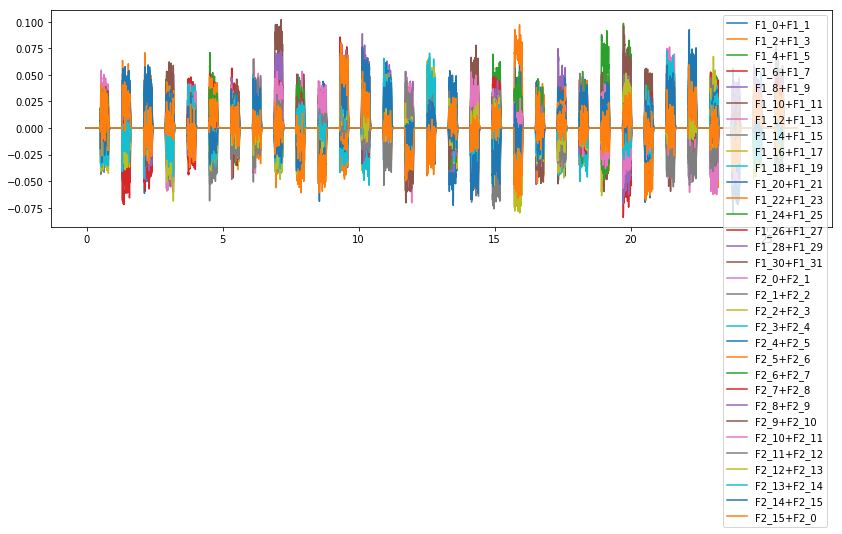

In [37]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], fan_vecs));
plt.legend(fan_labels)

## With Voja

In [39]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: 1-feed.paused)
    voja_learning = nengo.Node(lambda t: -feed.paused)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_learn = nengo.Probe(learning, synapse=None)
    p_v = nengo.Probe(voja_learning, synapse=None)

with nengo.Simulator(learned_model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 


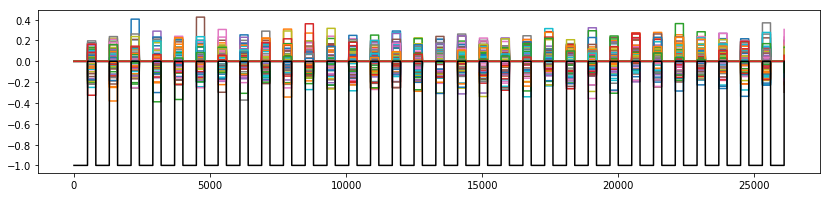

In [44]:
plt.figure(figsize=(14, 3))
plt.plot(sim.data[p_in]);
plt.plot(sim.data[p_v], color='k')

In [277]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=c*np.ones(n_neurons))

    conn_in = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(1e-6))
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_transform, synapse=rec_synapse)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] > 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)
    nengo.Connection(learning, conn_in.learning_rule, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.1)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:05.                                                 


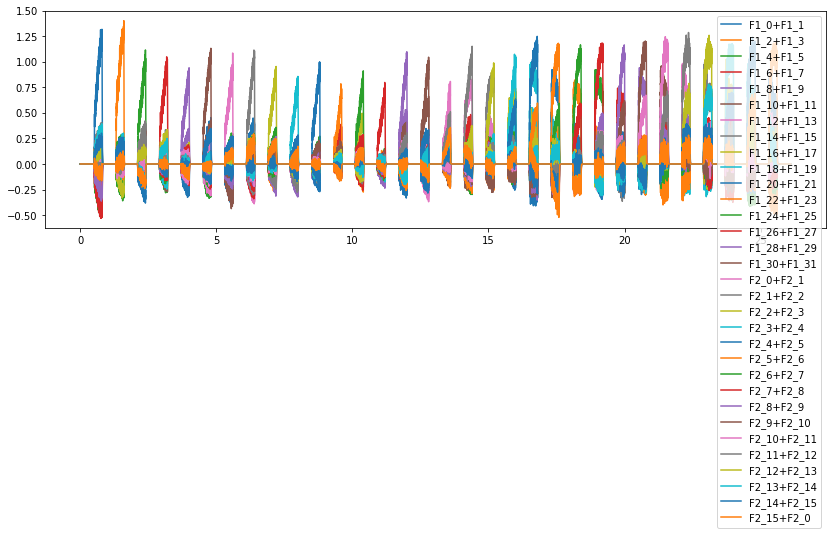

In [278]:
plt.figure(figsize=(14, 4))
plt.plot(learned_sim.trange(), spa.similarity(learned_sim.data[p_out], fan_vecs))
plt.legend(fan_labels, loc=(1, 0));

In [279]:
dec = learned_sim.data[p_dec][-1].copy()
enc = learned_sim.data[p_enc][-1].copy()

In [292]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [293]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=c*np.ones(n_neurons))

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_transform, synapse=rec_synapse)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:35.                                                 


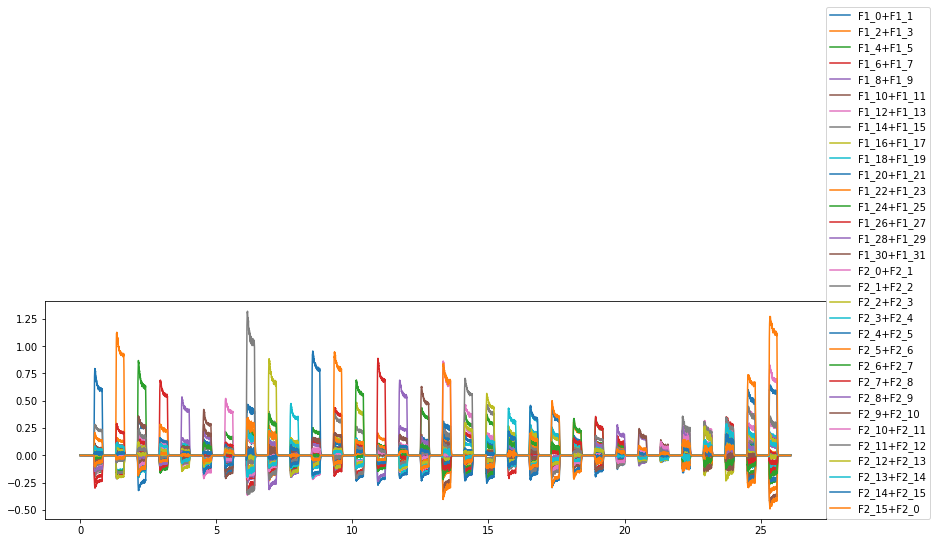

In [291]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], fan_vecs))
plt.legend(fan_labels, loc=(1, 0));

In [294]:
meg_resp = meg_from_spikes(test_sim.data[p_spikes])

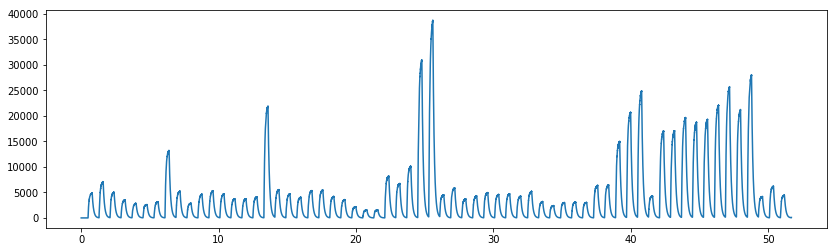

In [295]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), meg_resp)

In [296]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

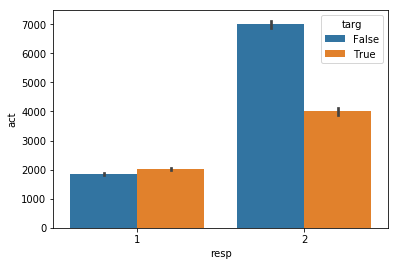

In [297]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

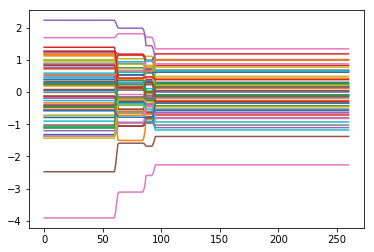

In [302]:
plt.plot(learned_sim.data[p_enc][:, 2, :]);